In [ ]:
from huggingface_hub import HfApi
import pandas as pd
import time
import itertools

api = HfApi()

def chunked_generator(gen, size):
    """Yield successive chunks of size from generator gen."""
    it = iter(gen)
    while True:
        chunk = list(itertools.islice(it, size))
        if not chunk:
            break
        yield chunk

def fetch_models_chunked(batch_size=5000, pause_sec=1):
    gen = api.list_models()
    data = []

    for chunk in chunked_generator(gen, batch_size):
        for m in chunk:
            provider, name = m.id.split("/") if "/" in m.id else ("N/A", m.id)
            data.append({
                "provider": provider,
                "model_name": name,
                "task": m.pipeline_tag or "",
                "created_at": m.created_at.isoformat() if m.created_at else None,
                "downloads": getattr(m, "downloads", 0),
                "downloads_all_time": getattr(m, "downloads_all_time", 0),
                "likes": getattr(m, "likes", 0),
            })

        time.sleep(pause_sec)  # avoid hammering API

    return data

data = fetch_models_chunked()

df = pd.DataFrame(data)
df.to_parquet("hf_models_chunked.parquet", index=False)



In [23]:
TASK_CATEGORY_MAP = {
    "any-to-any": "Multimodal",

    # Audio
    "audio-classification": "Audio",
    "audio-text-to-text": "Audio",
    "audio-to-audio": "Audio",
    "automatic-speech-recognition": "Audio",
    "text-to-audio": "Audio",
    "text-to-speech": "Audio",
    "voice-activity-detection": "Audio",

    # Computer Vision (CV)
    "image-classification": "CV",
    "image-feature-extraction": "CV",
    "image-segmentation": "CV",
    "image-to-image": "CV",
    "image-to-text": "CV",
    "keypoint-detection": "CV",
    "mask-generation": "CV",
    "object-detection": "CV",
    "zero-shot-image-classification": "CV",
    "zero-shot-object-detection": "CV",
    "unconditional-image-generation": "CV",
    "depth-estimation": "3D/Robotics",  # image-based depth → placed in 3D/Robotics

    # NLP
    "fill-mask": "NLP",
    "multiple-choice": "NLP",
    "question-answering": "NLP",
    "sentence-similarity": "NLP",
    "summarization": "NLP",
    "table-question-answering": "NLP",
    "table-to-text": "NLP",
    "text-classification": "NLP",
    "text-generation": "NLP",
    "text-ranking": "NLP",
    "text-retrieval": "NLP",
    "token-classification": "NLP",
    "translation": "NLP",
    "zero-shot-classification": "NLP",

    # Multimodal (mixed inputs/outputs, video, document tasks, cross-modal)
    "document-question-answering": "Multimodal",
    "feature-extraction": "Multimodal",        # ambiguous: generic feature extraction across modalities
    "image-text-to-text": "Multimodal",
    "image-to-video": "Multimodal",
    "text-to-image": "Multimodal",
    "text-to-video": "Multimodal",
    "video-classification": "Multimodal",
    "video-text-to-text": "Multimodal",
    "video-to-video": "Multimodal",
    "visual-document-retrieval": "Multimodal",
    "visual-question-answering": "Multimodal",

    # Tabular / Time Series
    "tabular-classification": "Tabular/TimeSeries",
    "tabular-regression": "Tabular/TimeSeries",
    "time-series-forecasting": "Tabular/TimeSeries",

    # 3D / Robotics
    "image-to-3d": "3D/Robotics",
    "text-to-3d": "3D/Robotics",
    "robotics": "3D/Robotics",

    # Reinforcement / Graph / Other
    "reinforcement-learning": "ReinforcementLearning",
    "graph-ml": "Graph",
    "other": "Other"
}


In [28]:
import pandas as pd

# Load parquet
df = pd.read_parquet("hf_models.parquet")

# Basic cleanup
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')

# Drop none task rows 
df = df[df['task'].notna()]

# Cleanup: created after 2016
df = df[df['created_at'] > '2016-01-01']

df["task_category"] = df["task"].map(TASK_CATEGORY_MAP).fillna("Unknown")

# 1) Timeseries: models created per month
models_per_month = df.groupby(df['created_at'].dt.to_period('M')).size()
print("Models created per month:")
print(models_per_month)

# 2) Aggregation by provider: total downloads and likes
provider_stats = df.groupby('provider').agg({
    'downloads': 'sum',
    'likes': 'sum',
    'model_name': 'count'
}).rename(columns={'model_name': 'model_count'})\
.sort_values('downloads', ascending=False)

print("\nProvider stats:")
print(provider_stats)

# 3) Task popularity
task_stats = df.groupby('task').agg({
    'downloads': ['sum', 'median'],
    'likes': ['sum', 'median'],
    'model_name': 'count'
})
task_stats.columns = ['_'.join(col).strip() for col in task_stats.columns.values]
task_stats = task_stats.sort_values('downloads_sum', ascending=False)

print("\nTask popularity:")
print(task_stats)

# 4) Category-level popularity
category_stats = df.groupby('task_category').agg({
    'downloads': ['sum', 'median'],
    'likes': ['sum', 'median'],
    'model_name': 'count'
})
category_stats.columns = ['_'.join(col).strip() for col in category_stats.columns.values]
category_stats = category_stats.sort_values('downloads_sum', ascending=False)

print("\nCategory popularity:")
print(category_stats)

/tmp/ipykernel_2641/770453949.py:18: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  models_per_month = df.groupby(df['created_at'].dt.to_period('M')).size()


Models created per month:
created_at
2022-03    20348
2022-04     2940
2022-05     4170
2022-06     3789
2022-07     3975
2022-08     3154
2022-09     2697
2022-10     3463
2022-11     4737
2022-12     7488
2023-01     8997
2023-02     9471
2023-03    11996
2023-04    10065
2023-05    10635
2023-06    10659
2023-07    15436
2023-08    14572
2023-09    14790
2023-10    15524
2023-11    20003
2023-12    17932
2024-01    19389
2024-02    19060
2024-03    20983
2024-04    24698
2024-05    28974
2024-06    25520
2024-07    23427
2024-08    16399
2024-09    17813
2024-10    19535
2024-11    25589
2024-12    24841
2025-01    28259
2025-02    29932
2025-03    32387
2025-04    35369
2025-05    29376
2025-06    28246
2025-07    25970
2025-08     6728
Freq: M, dtype: int64

Provider stats:
                       downloads  likes  model_count
provider                                            
sentence-transformers  146143270   9114          126
Falconsai              112745555   1220           1

In [29]:
df[df['task_category'] == 'Unknown']['task']

Series([], Name: task, dtype: object)

In [14]:
df_unknown = df[df['task_category'] == 'Unknown']

set(df_unknown['task'])

{None,
 'any-to-any',
 'audio-classification',
 'audio-text-to-text',
 'audio-to-audio',
 'automatic-speech-recognition',
 'depth-estimation',
 'document-question-answering',
 'feature-extraction',
 'fill-mask',
 'graph-ml',
 'image-classification',
 'image-feature-extraction',
 'image-segmentation',
 'image-text-to-text',
 'image-to-3d',
 'image-to-image',
 'image-to-text',
 'image-to-video',
 'keypoint-detection',
 'mask-generation',
 'multiple-choice',
 'object-detection',
 'other',
 'question-answering',
 'reinforcement-learning',
 'robotics',
 'sentence-similarity',
 'summarization',
 'table-question-answering',
 'table-to-text',
 'tabular-classification',
 'tabular-regression',
 'text-classification',
 'text-generation',
 'text-ranking',
 'text-retrieval',
 'text-to-3d',
 'text-to-audio',
 'text-to-image',
 'text-to-speech',
 'text-to-video',
 'time-series-forecasting',
 'token-classification',
 'translation',
 'unconditional-image-generation',
 'video-classification',
 'video-te

TypeError: Invalid object type at position 0

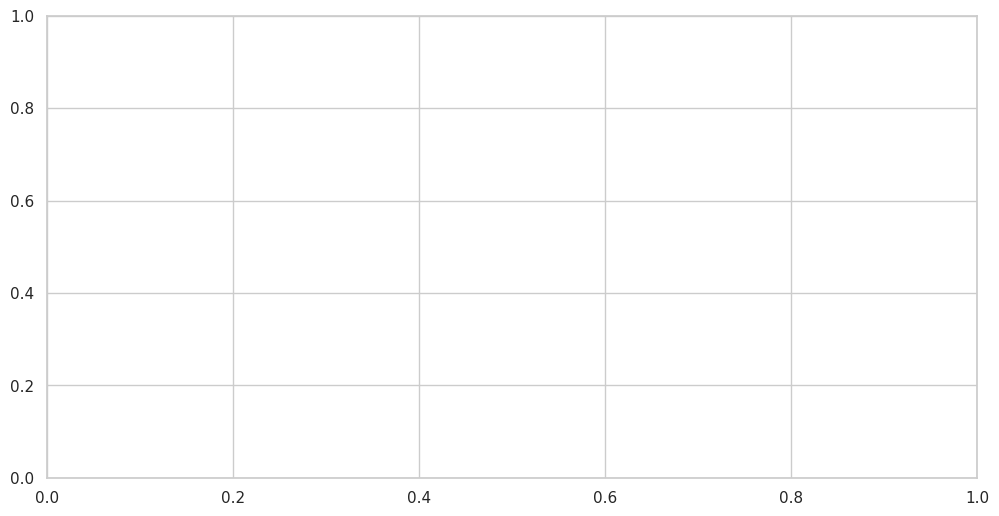

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# models_per_month.index is already DatetimeIndex, no conversion needed

plt.figure(figsize=(12, 6))
sns.lineplot(x=models_per_month.index, y=models_per_month.values)
plt.title("Models Created Per Month on Hugging Face Hub")
plt.xlabel("Month")
plt.ylabel("Number of Models Created")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
len(df[df['task'] == None])

0

In [33]:
print(type(monthly_pct.index))
print(monthly_pct.index[:5])
print(monthly_pct.index.dtype)

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
DatetimeIndex(['2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01'],
              dtype='datetime64[ns]', name='month', freq=None)
datetime64[ns]


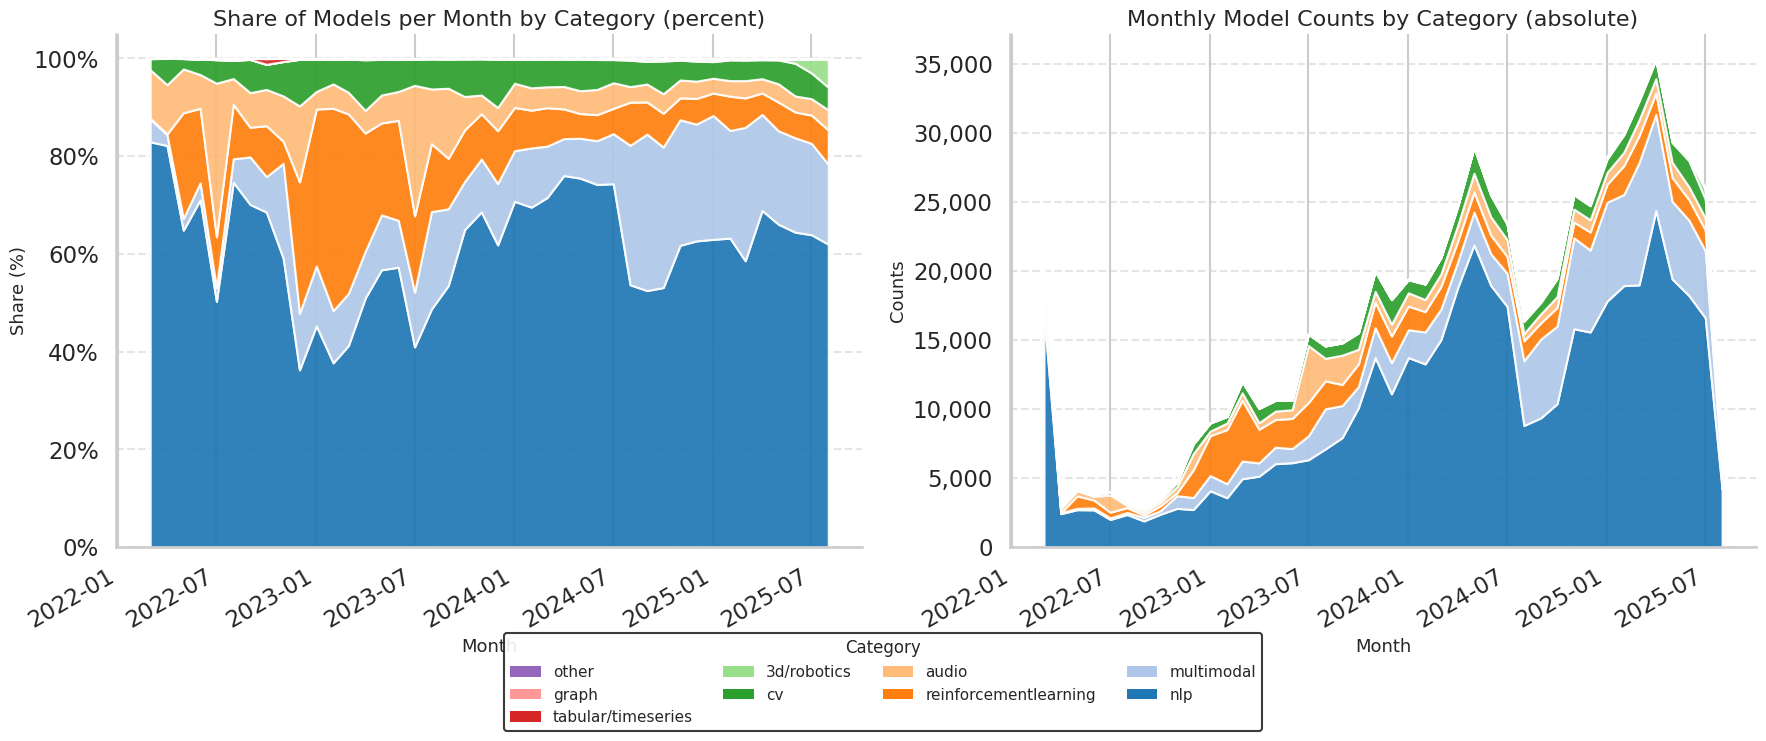

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import seaborn as sns
from matplotlib.patches import Patch

# Styling baseline
sns.set_theme(style="whitegrid")
sns.set_context("talk", rc={"axes.titlesize": 16, "axes.labelsize": 13, "legend.fontsize": 11})

# ---- Parameters ----
TOP_N = 8

# ---- Prepare data (defensive) ----
df['task_category'] = df['task_category'].astype(str).str.strip().str.lower()
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
df = df[~df['created_at'].isna()].copy()
df['month'] = df['created_at'].dt.to_period('M').dt.to_timestamp()

monthly_counts = df.groupby(['month', 'task_category']).size().unstack(fill_value=0)
full_index = pd.date_range(start=monthly_counts.index.min(), end=monthly_counts.index.max(), freq='MS')
monthly_counts = monthly_counts.reindex(full_index, fill_value=0)
monthly_counts.index.name = 'month'

top_cats = monthly_counts.sum().sort_values(ascending=False).index
monthly_top = monthly_counts.reindex(columns=top_cats, fill_value=0).copy()
other_cols = [c for c in monthly_counts.columns if c not in top_cats]
if other_cols:
    monthly_top['other'] = monthly_counts[other_cols].sum(axis=1)

monthly_abs = monthly_top.sort_index()
monthly_pct = monthly_abs.div(monthly_abs.sum(axis=1).replace(0, 1), axis=0) * 100
monthly_pct = monthly_pct.fillna(0)

# Order categories by total (descending) so big ones are at bottom of the stack
ordered_cols = monthly_abs.sum().sort_values(ascending=False).index.tolist()
monthly_abs = monthly_abs[ordered_cols]
monthly_pct = monthly_pct[ordered_cols]

# Color palette (distinct colors)
palette = sns.color_palette("tab20", n_colors=len(ordered_cols))
colors = palette

# x as matplotlib date numbers
x = mdates.date2num(monthly_abs.index.to_pydatetime())

# ---- Create side-by-side figures ----
fig, (ax_pct, ax_abs) = plt.subplots(1, 2, figsize=(18, 7), sharex=True)

# --- Percent plot (left) ---
ax_pct.stackplot(x, monthly_pct.T.values, labels=ordered_cols, colors=colors, alpha=0.92)

ax_pct.xaxis.set_major_locator(mdates.AutoDateLocator())
ax_pct.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax_pct.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax_pct.set_title("Share of Models per Month by Category (percent)")
ax_pct.set_ylabel("Share (%)")
ax_pct.grid(axis='y', linestyle='--', alpha=0.5)
ax_pct.set_xlabel("Month")

# --- Absolute counts plot (right) ---
ax_abs.stackplot(x, monthly_abs.T.values, labels=ordered_cols, colors=colors, alpha=0.92)

ax_abs.xaxis.set_major_locator(mdates.AutoDateLocator())
ax_abs.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax_abs.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
ax_abs.set_title("Monthly Model Counts by Category (absolute)")
ax_abs.set_ylabel("Counts")
ax_abs.grid(axis='y', linestyle='--', alpha=0.5)
ax_abs.set_xlabel("Month")

# Tidy up spines for a cleaner look
for ax in (ax_pct, ax_abs):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Rotate and format x labels
fig.autofmt_xdate(rotation=30)

# ---- Improved legend: single, readable, below the plots ----
handles = [Patch(facecolor=colors[i], edgecolor='none', label=lab) for i, lab in enumerate(ordered_cols)]
legend_cols = min(4, len(handles))
# Place legend below the two axes, centered
fig.legend(handles[::-1], [h.get_label() for h in handles[::-1]],
           title="Category", ncol=legend_cols, frameon=True,
           loc='lower center', bbox_to_anchor=(0.5, -0.08),
           fancybox=True, framealpha=0.9, edgecolor='0.15', fontsize=11, title_fontsize=12)

# Make space for the legend
plt.subplots_adjust(bottom=0.18, left=0.06, right=0.94)

plt.tight_layout()
plt.show()


Selected 254 providers covering 95.01% of downloads:
 1. sentence-transformers — 146,143,270 downloads — cumulative 9.71%
 2. Falconsai — 112,745,555 downloads — cumulative 17.20%
 3. Qwen — 87,397,383 downloads — cumulative 23.01%
 4. timm — 83,627,128 downloads — cumulative 28.56%
 5. google-bert — 71,825,771 downloads — cumulative 33.33%
 6. OpenMed — 70,406,143 downloads — cumulative 38.01%
 7. dima806 — 61,100,477 downloads — cumulative 42.07%
 8. openai — 52,138,925 downloads — cumulative 45.54%
 9. pyannote — 47,914,526 downloads — cumulative 48.72%
10. facebook — 44,312,731 downloads — cumulative 51.66%
11. microsoft — 39,967,680 downloads — cumulative 54.32%
12. FacebookAI — 39,231,309 downloads — cumulative 56.93%
13. amazon — 38,802,768 downloads — cumulative 59.50%
14. meta-llama — 29,199,201 downloads — cumulative 61.44%
15. google — 29,134,564 downloads — cumulative 63.38%
16. BAAI — 24,193,057 downloads — cumulative 64.99%
17. jonatasgrosman — 24,068,401 downloads — cumu

/tmp/ipykernel_2641/1866911016.py:64: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


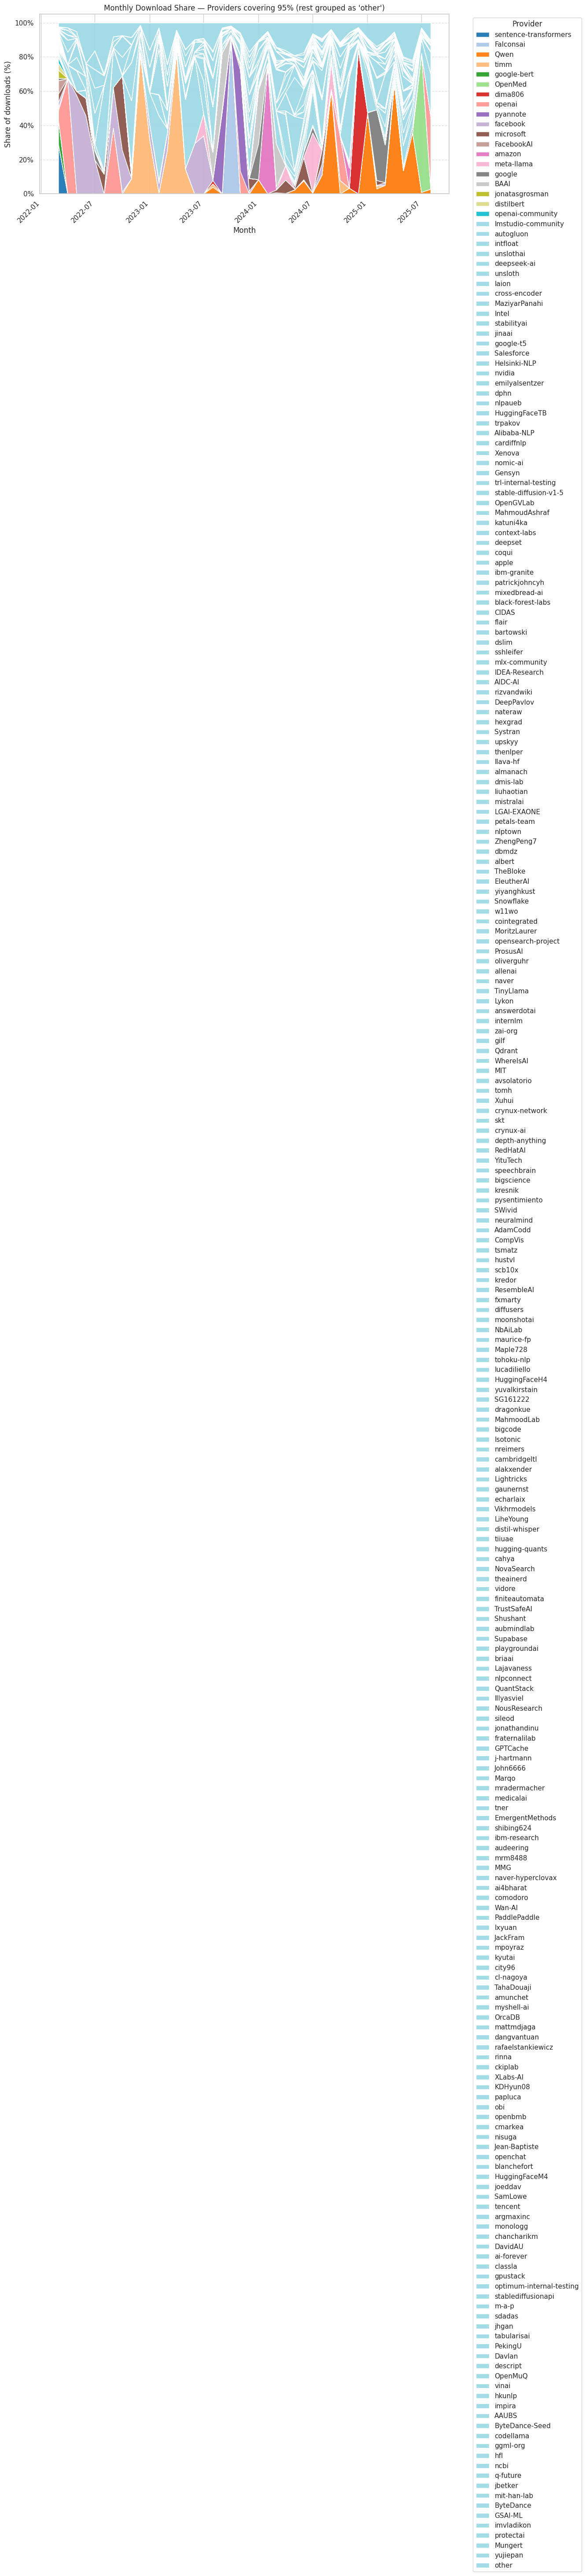

/tmp/ipykernel_2641/1866911016.py:81: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


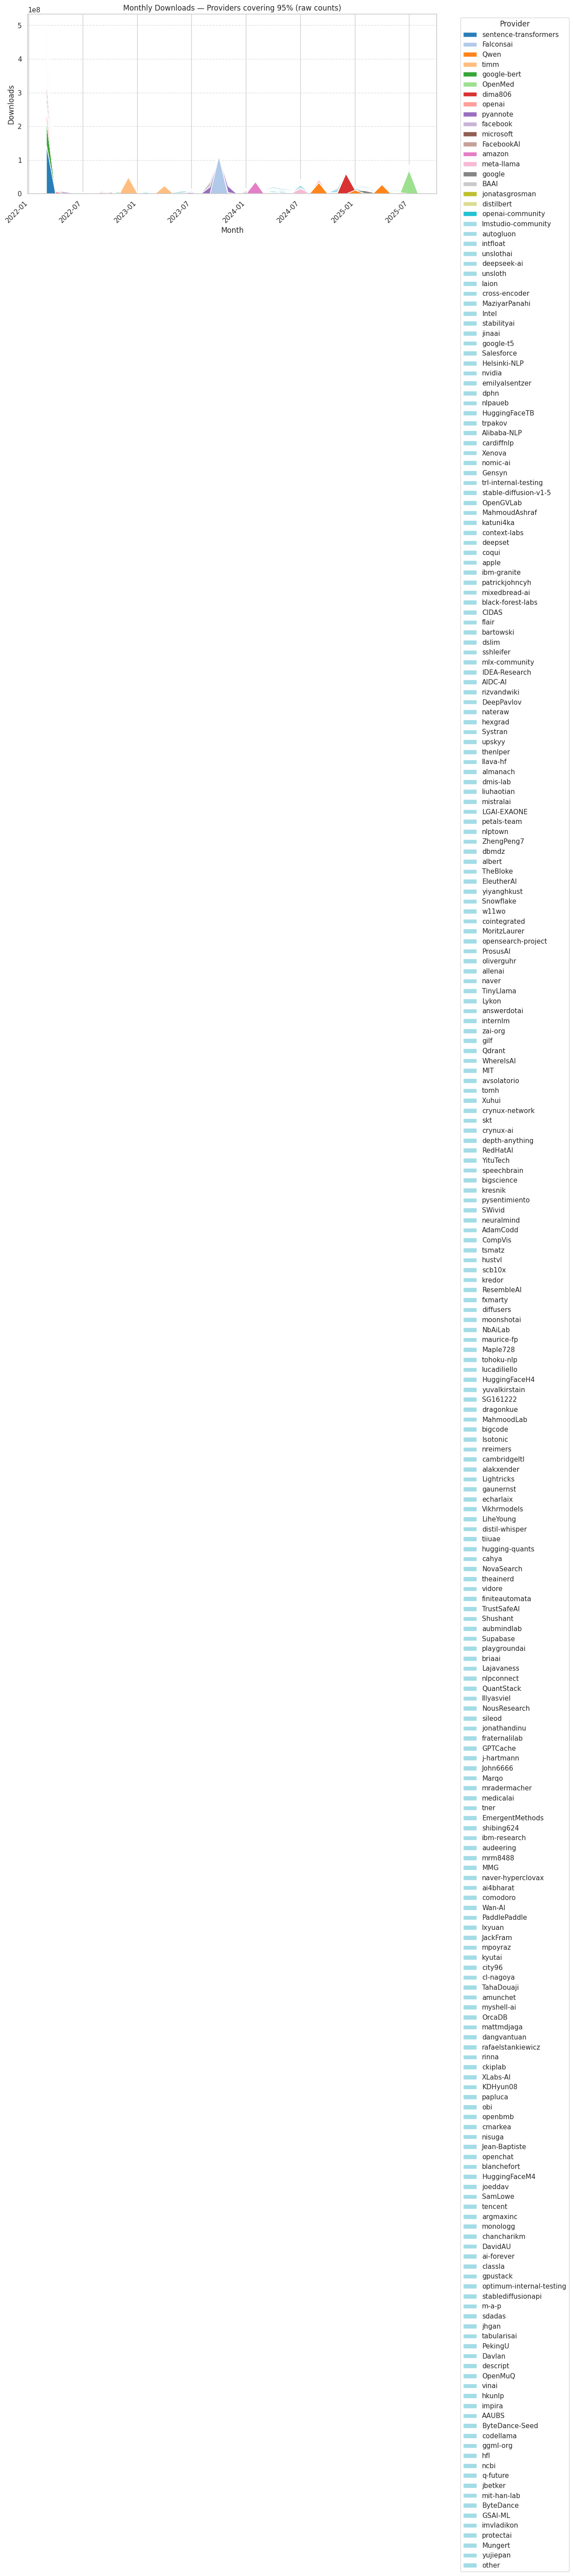

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import seaborn as sns

sns.set_theme(style="whitegrid")

# --- prepare / sanity ---
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
df = df[~df['created_at'].isna()].copy()
df['month'] = df['created_at'].dt.to_period('M').dt.to_timestamp()

# total downloads per provider (descending)
total_by_provider = df.groupby('provider')['downloads'].sum().sort_values(ascending=False)

# compute cumulative percent and select providers that make up 95% (including the provider that crosses 95%)
total = total_by_provider.sum()
cum_pct = (total_by_provider.cumsum() / total) * 100.0

selected = []
for provider, pct in cum_pct.items():
    selected.append(provider)
    if pct >= 95.0:
        break

print(f"Selected {len(selected)} providers covering {cum_pct.loc[selected[-1]]:.2f}% of downloads:")
for i, p in enumerate(selected, 1):
    print(f"{i:2d}. {p} — {total_by_provider.loc[p]:,} downloads — cumulative {cum_pct.loc[p]:.2f}%")

# --- monthly pivot for all providers ---
monthly_downloads = df.groupby(['month', 'provider'])['downloads'].sum().unstack(fill_value=0)

# ensure continuous monthly index
full_index = pd.date_range(monthly_downloads.index.min(), monthly_downloads.index.max(), freq='MS')
monthly_downloads = monthly_downloads.reindex(full_index, fill_value=0)
monthly_downloads.index.name = 'month'

# build table for selected providers + other
monthly_sel = monthly_downloads.reindex(columns=selected, fill_value=0).copy()
other_cols = [c for c in monthly_downloads.columns if c not in selected]
monthly_sel['other'] = monthly_downloads[other_cols].sum(axis=1) if other_cols else 0

# percent share per month
monthly_share = monthly_sel.div(monthly_sel.sum(axis=1).replace(0, 1), axis=0).fillna(0) * 100

# --- Plot: percent share over time (stacked area) ---
fig, ax = plt.subplots(figsize=(12, 6))
x = mdates.date2num(monthly_share.index.to_pydatetime())
colors = plt.get_cmap("tab20")(range(len(monthly_share.columns)))
ax.stackplot(x, monthly_share.T.values, labels=monthly_share.columns, colors=colors, alpha=0.95)

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.xaxis_date()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))

fig.autofmt_xdate(rotation=45)
ax.set_title("Monthly Download Share — Providers covering 95% (rest grouped as 'other')")
ax.set_xlabel("Month")
ax.set_ylabel("Share of downloads (%)")
ax.legend(title="Provider", bbox_to_anchor=(1.05, 1), loc="upper left")
ax.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- Plot: raw downloads over time (stacked area) ---
fig, ax = plt.subplots(figsize=(12, 6))
x = mdates.date2num(monthly_sel.index.to_pydatetime())
ax.stackplot(x, monthly_sel.T.values, labels=monthly_sel.columns, colors=colors, alpha=0.95)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.xaxis_date()

fig.autofmt_xdate(rotation=45)
ax.set_title("Monthly Downloads — Providers covering 95% (raw counts)")
ax.set_xlabel("Month")
ax.set_ylabel("Downloads")
ax.legend(title="Provider", bbox_to_anchor=(1.05, 1), loc="upper left")
ax.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


/tmp/ipykernel_15321/259468183.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_tasks['downloads_sum'], y=top_tasks.index, palette="magma")


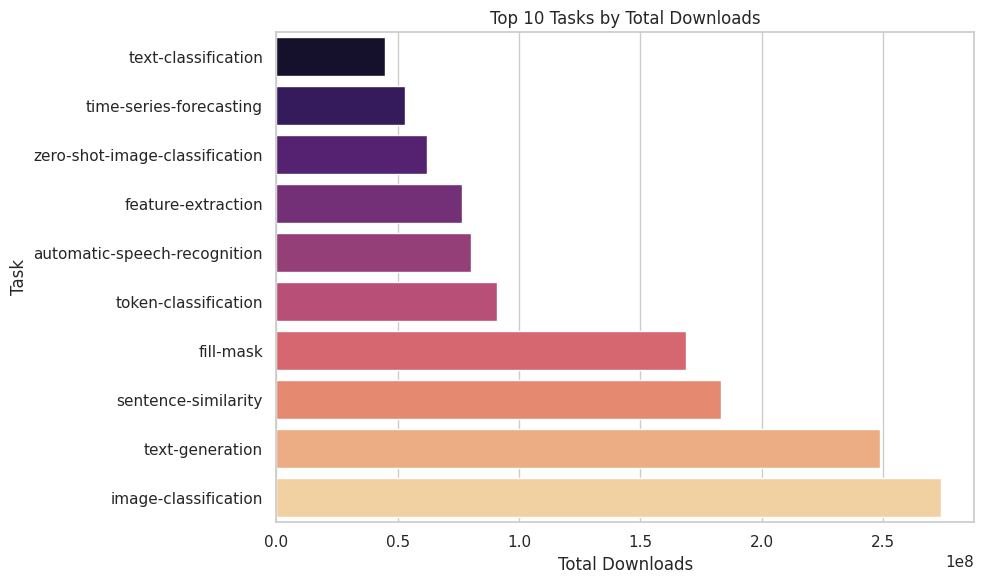

In [7]:
top_tasks = task_stats.head(10).sort_values('downloads_sum', ascending=True)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_tasks['downloads_sum'], y=top_tasks.index, palette="magma")
plt.title("Top 10 Tasks by Total Downloads")
plt.xlabel("Total Downloads")
plt.ylabel("Task")
plt.tight_layout()
plt.show()
